## 1. Importing required libraries

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

## 2. Loading the dataset

In [2]:
train_images_folder = "./dataset/train/images"
test_images_folder = "./dataset/test/images"

train_annotations_folder = "./dataset/train/annotations"
test_annotations_folder = "./dataset/test/annotations"


In [3]:
m_train = len(os.listdir(train_images_folder))
m_test = len(os.listdir(test_images_folder))

max_train_images_per_class = 2400
max_test_images_per_class = 400

num_classes = 10

# reading an image to figure out the dimensions 
img = cv2.imread(f"./dataset/train/images/0.png", cv2.IMREAD_GRAYSCALE)

h,w = img.shape

# Preallocate memory for the images and labels
train_images = np.empty((max_train_images_per_class * 10, h, w), dtype=np.float32)
train_labels = np.empty((max_train_images_per_class * 10, num_classes+4 ), dtype=np.float32)
test_images = np.empty((max_test_images_per_class * 10, h, w), dtype=np.float32)
test_labels = np.empty((max_test_images_per_class * 10, num_classes+4), dtype=np.float32)

print(f"Train data size: {max_train_images_per_class * 10}  |  Test data size: {max_test_images_per_class * 10}")

class_counts = {}

train_count = 0
# loading the train data (taking only 3000 images per class)
for i in range(m_train):
    
    if train_count == max_train_images_per_class * 10:
        print(f'Loaded {max_train_images_per_class} train images per class')
        break
    
    # reading the annotation to get labels
    with open(f"./dataset/train/annotations/{i}.txt") as f:
        labels_str = f.read().strip('\n')
        label , x_min , y_min , x_max , y_max = map(int, labels_str.split(' '))

    
    # checking if the counts of the current label are less than max_images_per_class
    if class_counts.get(label,0) < max_train_images_per_class:

        # reading the image
        img = cv2.imread(f"./dataset/train/images/{i}.png", cv2.IMREAD_GRAYSCALE)

        # normalize the image and store it
        train_images[train_count] = img / 255

        # One-hot encode the label
        one_hot_label = np.eye(num_classes)[label]
        
        # bounding box coordinates
        bbox_coordinates = np.array([x_min/w , y_min/h , x_max/w , y_max/h])

        # Concatenate one_hot_label and bbox_coordinates and store it
        train_labels[train_count] = np.concatenate((bbox_coordinates, one_hot_label))
        
        # updating the count
        class_counts[label] = class_counts.get(label,0) + 1
        train_count += 1


class_counts = {}

test_count = 0
# loading the test data (taking only 500 images per class)
for i in range(m_test):

    if test_count == max_test_images_per_class * 10:
        print(f'Loaded {max_test_images_per_class} test images per class')
        break
        
    # reading the annotation to get labels
    with open(f"./dataset/test/annotations/{i}.txt") as f:
        labels_str = f.read().strip('\n')
        label , x_min , y_min , x_max , y_max = map(int, labels_str.split(' '))
        
    # checking if the counts of the current label are less than max_images_per_class
    if class_counts.get(label,0) < max_test_images_per_class:
        
        # reading the image
        img = cv2.imread(f"./dataset/test/images/{i}.png", cv2.IMREAD_GRAYSCALE)

        # normalize the image
        test_images[test_count] = img / 255

        # One-hot encode the label
        one_hot_label = np.eye(num_classes)[label]
        
        # bounding box coordinates
        bbox_coordinates = np.array([x_min/w , y_min/h , x_max/w , y_max/h])

        # Concatenate one_hot_label and bbox_coordinates and store it
        test_labels[test_count] = np.concatenate((bbox_coordinates, one_hot_label))
        
        # updating the count
        class_counts[label] = class_counts.get(label,0) + 1
        test_count += 1



Train data size: 24000  |  Test data size: 4000
Loaded 2400 train images per class
Loaded 400 test images per class


In [4]:
# renaming our arrays
train_x = train_images
train_y = train_labels
test_x = test_images
test_y = test_labels

print(f" train_x shape: {train_x.shape} \n train_y shape: {train_y.shape} \n test_x shape: {test_x.shape} \n test_y shape: {test_y.shape}")

 train_x shape: (24000, 75, 75) 
 train_y shape: (24000, 14) 
 test_x shape: (4000, 75, 75) 
 test_y shape: (4000, 14)


### Reshaping our data for vectorized implementation 

In [5]:
# reshaping
train_x = train_x.reshape(train_x.shape[0],-1).T
test_x = test_x.reshape(test_x.shape[0],-1).T
train_y = train_y.T
test_y = test_y.T

print(f'Shape of train_X: {train_x.shape}')
print(f'Shape of train_Y: {train_y.shape}')
print(f'Shape of test_X: {test_x.shape}')
print(f'Shape of test_Y: {test_y.shape}')

Shape of train_X: (5625, 24000)
Shape of train_Y: (14, 24000)
Shape of test_X: (5625, 4000)
Shape of test_Y: (14, 4000)


#### Displaying a random picture from our dataset to see if we have reshaped correctly

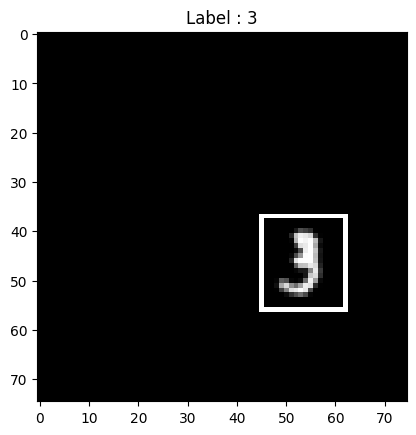

In [6]:
ind = 10

img = (train_x[:,ind]*255).reshape(h,w)

xmin,ymin,xmax,ymax = train_y[:4,ind]
label = np.argmax(train_y[4:,ind])

xmin = int(xmin * w)
xmax = int(xmax * w)
ymin = int(ymin * h)
ymax = int(ymax * h)


bbox = cv2.rectangle(img, (xmin,ymin), (xmax, ymax), (255,0,0) , 1)    # (pic , start , end , color, thickness)

plt.imshow(bbox , cmap='gray')
plt.title(f"Label : {label}")
plt.show()

# 4. Coding our Network

## a. Activation Functions
These functions will later be used at different layers in our network

In [7]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def relu(Z):
    A = np.maximum(0,Z)
    return A

def tanh(Z):
    A = np.tanh(Z)
    return A

# The derivatives of these functions are later used in our back propagation

def relu_prime(Z):     # derivatice of relu function 
    derivative = (Z > 0).astype(int)
    return derivative

def sigmoid_prime(Z):  # derivative of sigmoid function
    A = sigmoid(Z)
    derivative = A * (1 - A)
    return derivative

def tanh_prime(Z):     # derivative of tanh function
    A = tanh(Z)
    derivative = 1 - np.square(A)
    return derivative


## b. Initialization of Parameters
Visit the link below to know more <br>
[Weight Initialization Techniques in Neural Networks](https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78)

In [8]:
def intialize_parameters(layers_dims,activation_functions):
    parameters = {}
    L = len(layers_dims)
    # the different initialization methods help us in avoiding vanishing and exploding gradients 
    
    for l in range(1,L):
        if activation_functions[l] == "relu":
            # He initialization for ReLU activation
            parameters["W" + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2/layers_dims[l-1])
            
        elif activation_functions[l] == "sigmoid" or activation_functions[l] == "tanh" or activation_functions[l] == "softmax":
            # Xavier/Glorot initialization for Sigmoid or Tanh activation
            parameters["W" + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(1/layers_dims[l-1])
            
        else:
            # Default initialization for other activations
            parameters["W" + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 0.01
            
        parameters["b" + str(l)] = np.zeros((layers_dims[l],1))

    return parameters

## c. Forward Propagation

In [9]:
def linear_forward(A,W,b):
    Z = np.dot(W,A) + b
    return Z

def linear_activation_forward(A,W,b,activation):
    Z = linear_forward(A,W,b)

    if activation == 'relu':
        A = relu(Z)
    elif activation == 'sigmoid':
        A = sigmoid(Z)
    elif activation == 'softmax':
        A = softmax(Z)
    elif activation == 'tanh':
        A = tanh(Z)
    else:
        A = Z

    return A, Z

def L_model_Forward(X, parameters, layers_dims, activation_functions):
    activations = {}
    L = len(layers_dims)

    A_prev = X
    
    for l in range(1,L):
        activations["A"+str(l)], activations["Z"+str(l)] = linear_activation_forward(A_prev,parameters["W"+str(l)]
                                                                                     ,parameters["b"+str(l)], activation_functions[l])
        A_prev = activations["A"+str(l)]
        
    # A1, Z1 = linear_activation_forward(X,parameters["W1"],parameters["b1"],"relu")
    # A2, Z2 = linear_activation_forward(A1,parameters["W2"],parameters["b2"],"relu")
    # A3, Z3 = linear_activation_forward(A2,parameters["W3"],parameters["b3"],"softmax")

    return activations

## d. Cost Function

In [54]:
# Both of these will work only for this particular task. since we are taking softmax in the cost function

def compute_cost(A , Y):     # A = Y_hat : output layer activations, Y: Output true labels
    m = Y.shape[1]

    # Split A into bounding box and class labels
    A_box = A[:4,:]
    A_class = A[4:,:]

    # Apply softmax to A_class
    A_class = softmax(A_class)

    # Split Y into bounding box and class labels
    Y_box = Y[:4,:]
    Y_class = Y[4:,:]

    # MSE for bounding boxes
    mse = np.mean(np.square(Y_box - A_box))
    
    # Cross entropy loss for class labels
    c_entropy = -1 * (np.mean(Y_class * np.log(A_class + 1e-8)))

    cost_value =  mse + c_entropy
    
    return cost_value

def compute_dZ(A, Y):
    # Split A into bounding box and class labels

    A_box = A[:4,:]
    A_class = A[4:,:]
    
    # Apply softmax to A_class
    A_class = softmax(A_class)
    
    # Split Y into bounding box and class labels
    Y_box = Y[:4,:]
    Y_class = Y[4:,:]

    # Compute dZ for bounding boxes
    dZ_box = 2 * (A_box - Y_box)

    # Compute dZ for class labels
    dZ_class = A_class - Y_class

    # Concatenate dZ_box and dZ_class to get dZ
    dZ = np.concatenate((dZ_box, dZ_class), axis=0)

    return dZ

    

## e. Backward Propagation

In [55]:
def L_model_backward(activations, parameters , X,Y, layers_dims, activation_functions):
    derivatives = {}
    L = len(layers_dims)
    m = Y.shape[1]
    last_layer = str(L -1)

    for l in reversed(range(1,L)):
        if l == L-1:
            # first derivatice w.r.t cost function (last layer) 
            # should be change if you are using any other cost function
            derivatives["dZ"+str(l)] = compute_dZ(activations["A"+str(l)], Y)
        else:
            if activation_functions[l] == 'relu':
                derivatives["dZ"+str(l)] = (np.dot(parameters["W"+str(l+1)].T,derivatives["dZ"+str(l+1)])) * (relu_prime(activations["Z"+str(l)]))
            elif activation_functions[l] == 'sigmoid':
                derivatives["dZ"+str(l)] = (np.dot(parameters["W"+str(l+1)].T,derivatives["dZ"+str(l+1)])) * (sigmoid_prime(activations["Z"+str(l)]))
            elif activation_functions[l] == 'tanh':
                derivatives["dZ"+str(l)] = (np.dot(parameters["W"+str(l+1)].T,derivatives["dZ"+str(l+1)])) * (tanh_prime(activations["Z"+str(l)]))
            elif activation_functions[l] == 'linear':
                derivatives["dZ"+str(l)] = (np.dot(parameters["W"+str(l+1)].T,derivatives["dZ"+str(l+1)])) * (activations["Z"+str(l)])
            


        if l == 1:
            derivatives["dW"+str(l)] = (1/m) * np.dot(derivatives["dZ"+str(l)], X.T)
        else:
            derivatives["dW"+str(l)] = (1/m) * np.dot(derivatives["dZ"+str(l)], activations["A"+str(l-1)].T)
            
        derivatives["db"+str(l)] = (1/m) * (np.sum(derivatives["dZ"+str(l)], axis=1 , keepdims=True))

    return derivatives

## f. Update Parameters

In [56]:
def update_params(parameters, derivatives, alpha, layers_dims):
    L = len(layers_dims)

    for l in range(1,L):
        parameters["W"+str(l)] = parameters["W"+str(l)] - (alpha * derivatives["dW"+str(l)])
        parameters["b"+str(l)] = parameters["b"+str(l)] - (alpha * derivatives["db"+str(l)])
          
    return parameters

## g. Mini Batch Gradient Descent

In [63]:
def Gradient_Descent(X,Y,alpha,epochs, mini_batch_size , layers_dims, activation_functions, X_test, Y_test):
    train_costs = []
    test_costs = []
    train_ious = []
    test_ious = []
    
    parameters = intialize_parameters(layers_dims, activation_functions)
    
    L = len(layers_dims)
    m = X.shape[1]
    
    for i in tqdm(range(epochs)):
        for k in range(0,m,mini_batch_size):
            minibatch_X = X[:, k:k+mini_batch_size]
            minibatch_Y = Y[:, k:k+mini_batch_size]
            
            activations = L_model_Forward(minibatch_X, parameters, layers_dims, activation_functions)
            
            derivatives = L_model_backward(activations, parameters, minibatch_X, minibatch_Y, layers_dims, activation_functions)
            
            parameters = update_params(parameters, derivatives, alpha, layers_dims)
    

        # computing cost on train and test after one epoch
        train_activations = L_model_Forward(X, parameters, layers_dims, activation_functions)
        test_activations = L_model_Forward(X_test, parameters, layers_dims, activation_functions)
        
        train_cost = compute_cost(train_activations["A"+str(L-1)] , Y)
        test_cost = compute_cost(test_activations["A"+str(L-1)] , Y_test)
        
        train_costs.append(train_cost)
        test_costs.append(test_cost)

        # computing iou on train and test after one epoch
        train_iou = compute_iou(train_activations["A"+str(L-1)][:4,:] , Y[:4,:])
        test_iou = compute_iou(test_activations["A"+str(L-1)][:4,:] , Y_test[:4,:])

        train_ious.append(train_iou)
        test_ious.append(test_iou)

        # if (i%10 ==0):
        #     print(f"Train Cost : {train_cost}  |  Test Cost : {test_cost}")

    return parameters, train_costs, test_costs , train_ious, test_ious

## 5. Functions to plot results of our Models

In [72]:
# vectorized implementation
def compute_iou(A , B):

    if A.shape != B.shape:
        print("The shapes of both arrays should be same")
        return None

    m = A.shape[1]
        
    # calculate intersection area
    intersection_width = np.minimum(A[2,:] , B[2,:]) - np.maximum(A[0,:] , B[0,:])  # right - left / xmax - xmin
    intersection_height = np.minimum(A[3,:] , B[3,:]) - np.maximum(A[1,:] , B[1,:])  # bottom - top / xmax - xmin

    # if there is no intersection 
    intersection_width = np.maximum(0,intersection_width)
    intersection_height = np.maximum(0,intersection_height)

    intersection_area = intersection_height * intersection_width

    # Union area
    A_area = (A[2,:] - A[0,:]) * (A[3,:] - A[1,:])         # right - left * bottom - top   / width * height
    B_area = (B[2,:] - B[0,:]) * (B[3,:] - B[1,:])

    union_area = A_area + B_area - intersection_area

    iou = intersection_area / union_area

    iou = np.sum(iou) / m           # averaging over all examples

    return iou
    

# function to denormalize boundind box coordinates
def denormalize(A,w,h):   # A [ [xmin,ymin,xmax,ymax]    , no  of examples]
    A = A.copy()

    if len(A.shape) == 1: # for a single example
        A = A.reshape(-1,1)
        
    A[0,:] = A[0,:] * w
    A[1,:] = A[1,:] * h
    A[2,:] = A[2,:] * w
    A[3,:] = A[3,:] * h
    A = A.astype(int)
    
    return A

# function to plot metrics
def plot_metrics(train_costs, test_costs, train_ious, test_ious, learning_rate):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plotting Costs
    axs[0].plot(train_costs, label='Train Cost', color='blue')
    axs[0].plot(test_costs, label='Test Cost', color='red')
    axs[0].set_ylabel('Cost')
    axs[0].set_xlabel('Epochs')
    axs[0].set_title("Learning rate =" + str(learning_rate))
    axs[0].legend()

    # Plotting IOUs
    axs[1].plot(train_ious, label='Train IOU', color='blue')
    axs[1].plot(test_ious, label='Test IOU', color='red')
    axs[1].set_ylabel('IOU')
    axs[1].set_xlabel('Epochs')
    axs[1].set_title("Learning rate =" + str(learning_rate))
    axs[1].legend()

    plt.tight_layout()
    plt.show()

def plot_bbox(index,w,h,params,layers_dims,activation_functions):       # plots ground truth and predicted bbox for image at provided index of the TEST Set 
    
    # denormalizing our ground truth bbox coordinates
    img_bbox = denormalize(test_y[:4,index],w,h)
    # Squeeze the array
    img_bbox = np.squeeze(img_bbox).astype(int)

    # Plotting 
    plt.figure(figsize=(10,5))

    # true class label 
    label = np.argmax(test_y[4:,index])
    
    # Ground Truth
    plt.subplot(1,2,1)
    plt.title(f"Ground Truth label : {label}")
    img = (test_x[:,index]*255).reshape(h,w)
    xmin,ymin,xmax,ymax = img_bbox

    img = cv2.rectangle(img, (xmin,ymin), (xmax, ymax), (255,0,0) , 1)    # (pic , start , end , color, thickness)
    plt.imshow(img,cmap='gray')

    
    # Prediction
    pred_image = test_x[:,index].reshape(-1, 1)
    activation = L_model_Forward(pred_image, params, layers_dims, activation_functions)
    
    pred = activation["A" + str(len(layers_dims)-1)]

    # predicted class label 
    label = np.argmax(softmax(pred[4:]))
    
    # denormalizing our predicted bbox coordinates
    img_bbox = denormalize(pred[:4],w,h)
    # Squeeze the array
    img_bbox = np.squeeze(img_bbox).astype(int)

    xmin,ymin,xmax,ymax = img_bbox
    
    img = (test_x[:,index]*255).reshape(75,75)
    img = cv2.rectangle(img, (xmin,ymin), (xmax, ymax), (255,0,0) , 1)    # (pic , start , end , color, thickness)
    
    plt.subplot(1,2,2)
    plt.title(f"Predicted label : {label}")
    plt.imshow(img,cmap='gray')
    
    plt.show()


## 6. Training our different Models

100%|███████████████████████████████████████████| 50/50 [03:49<00:00,  4.59s/it]


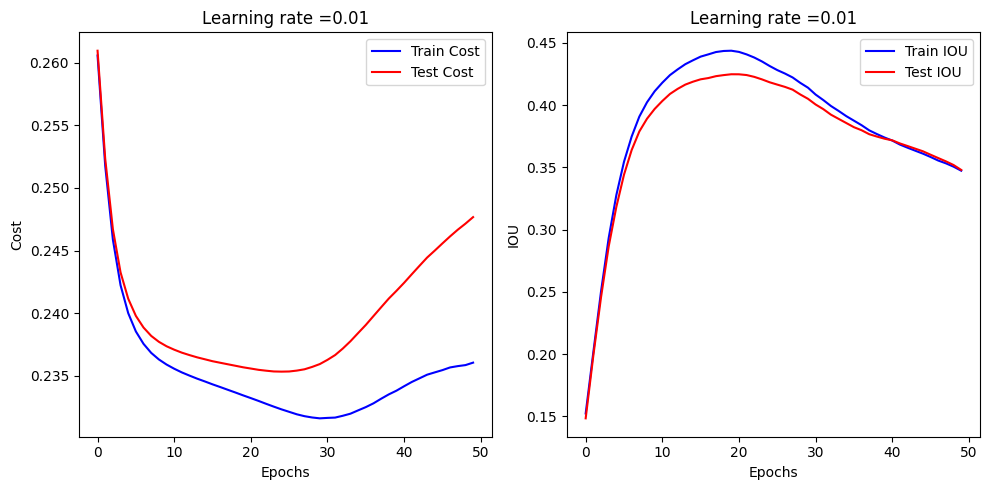

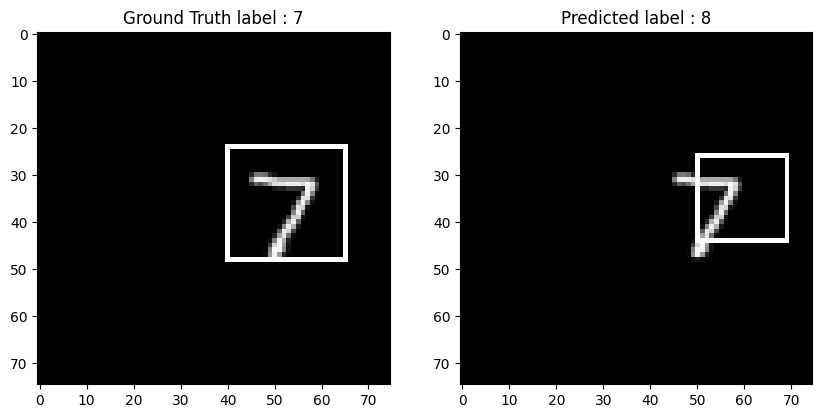

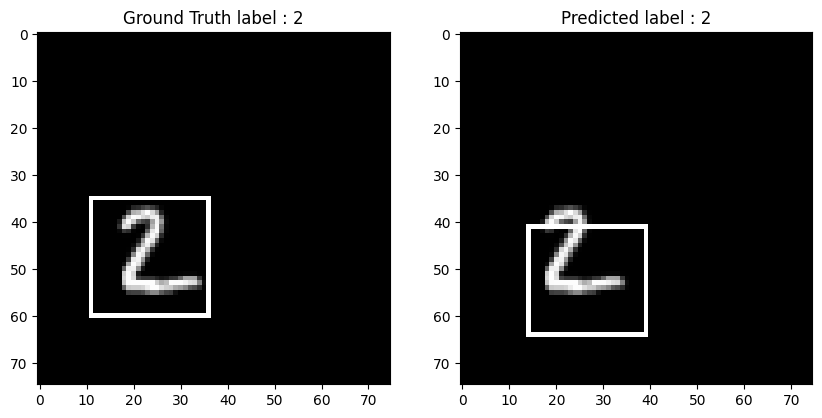

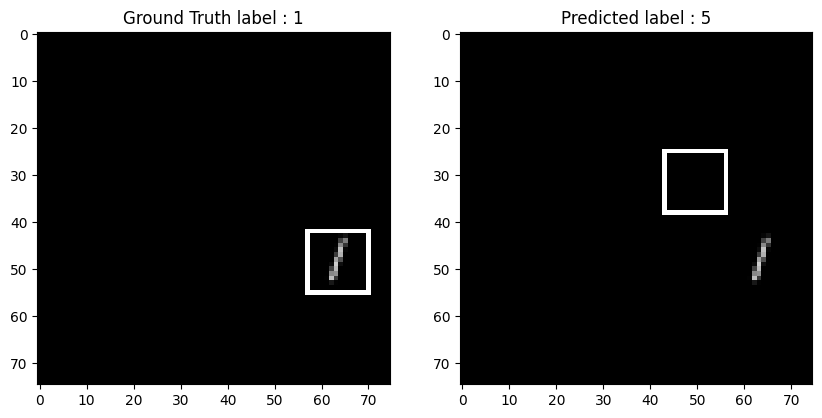

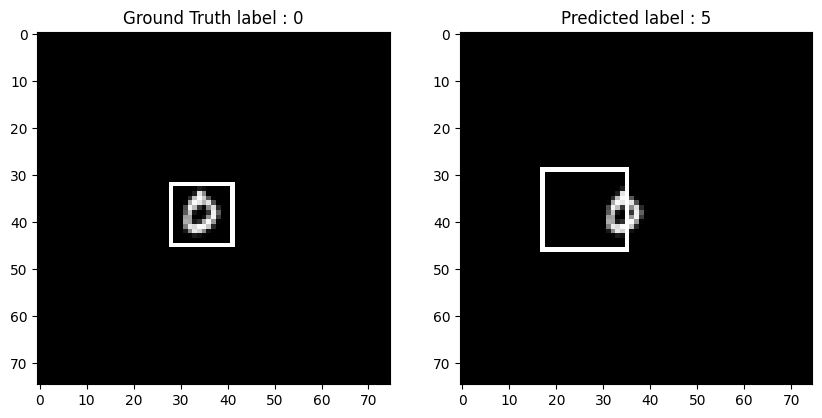

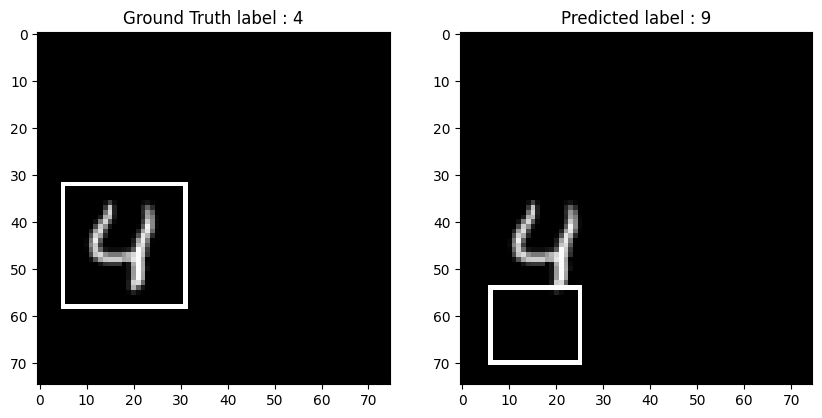

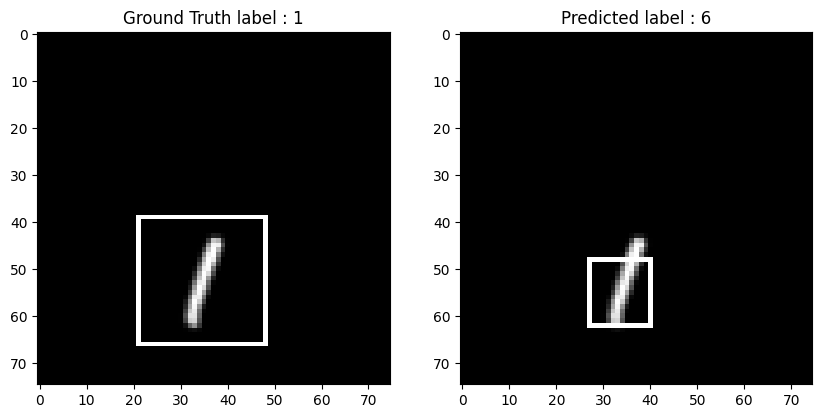

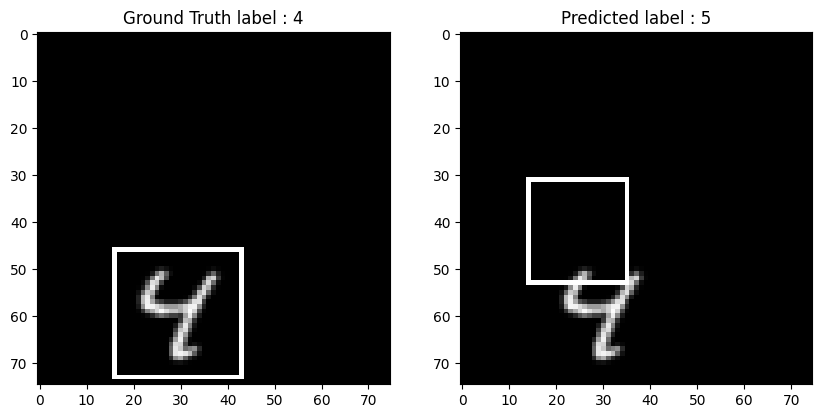

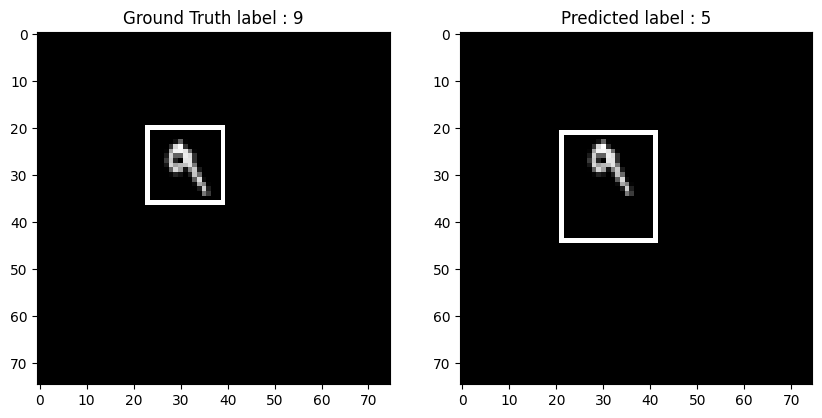

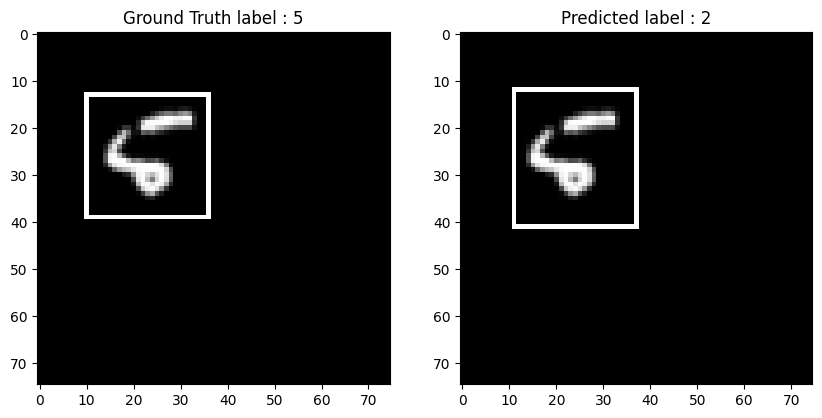

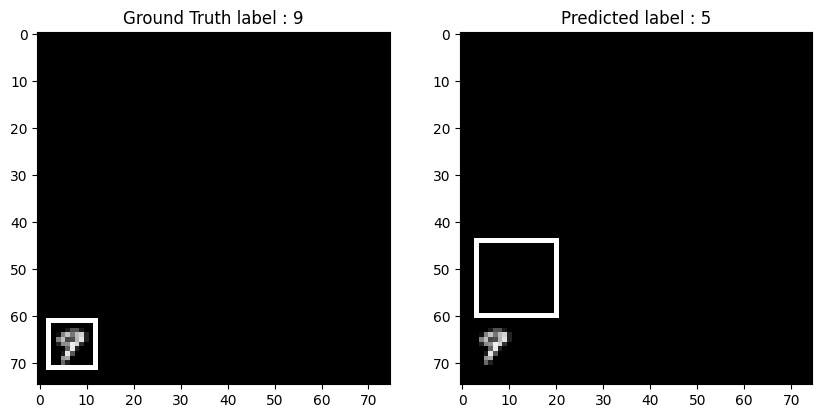

In [84]:
layers_dims = [w * h,10,10,14]         #  w * h is the dimension of input layer
activation_functions = ["", "relu","relu", "relu"]  # first column is blank because there is no activation from the input layer
learning_rate = 0.01
epochs = 50
mini_batch_size = 64

# Training our model using gradient descent
params, train_costs, test_costs , train_ious, test_ious = Gradient_Descent(train_x,train_y,learning_rate,epochs,mini_batch_size, layers_dims, activation_functions, test_x , test_y)

# plotting metrics of our model
plot_metrics(train_costs, test_costs, train_ious, test_ious, learning_rate)

# making prediction on our test set
for i in range(10):
    plot_bbox(i ,w,h,params,layers_dims,activation_functions)

100%|███████████████████████████████████████████| 50/50 [02:34<00:00,  3.09s/it]


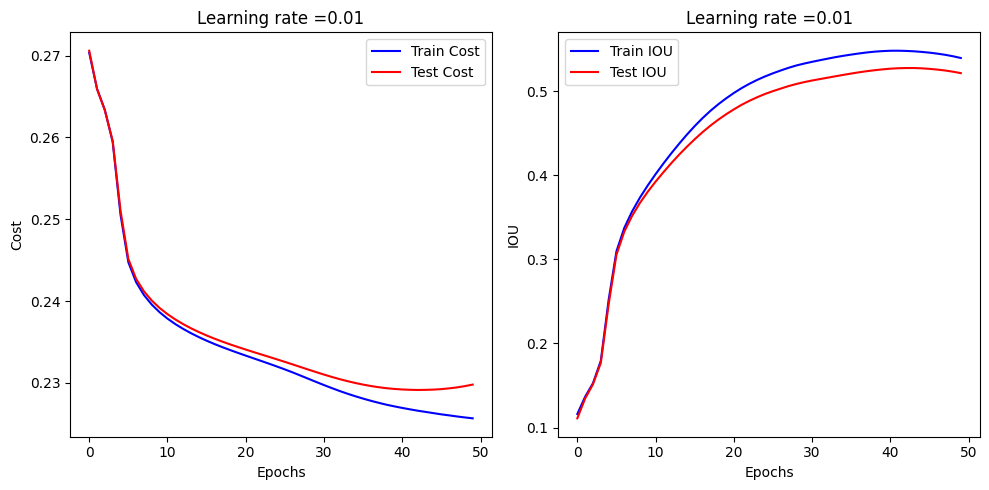

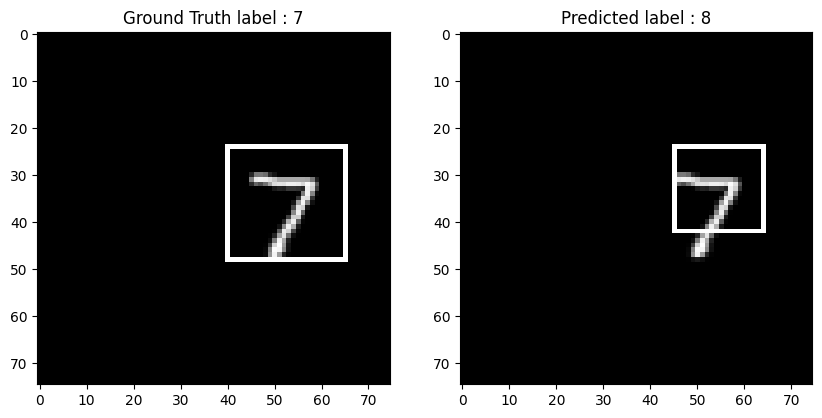

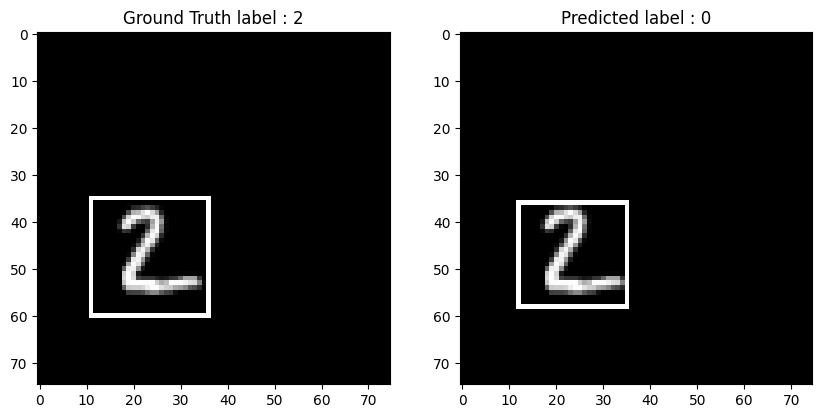

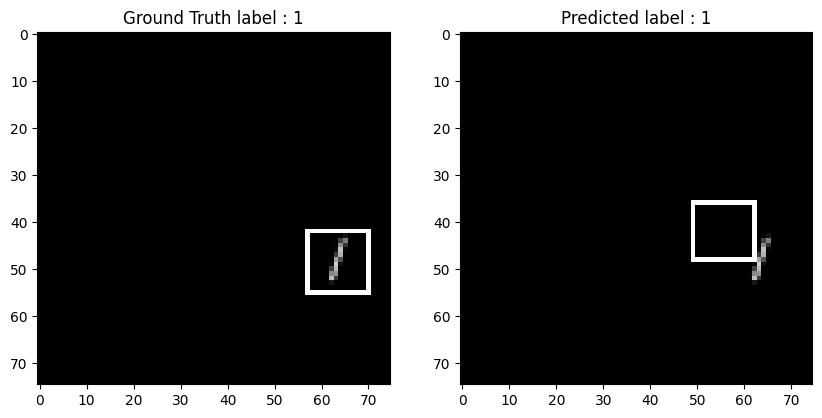

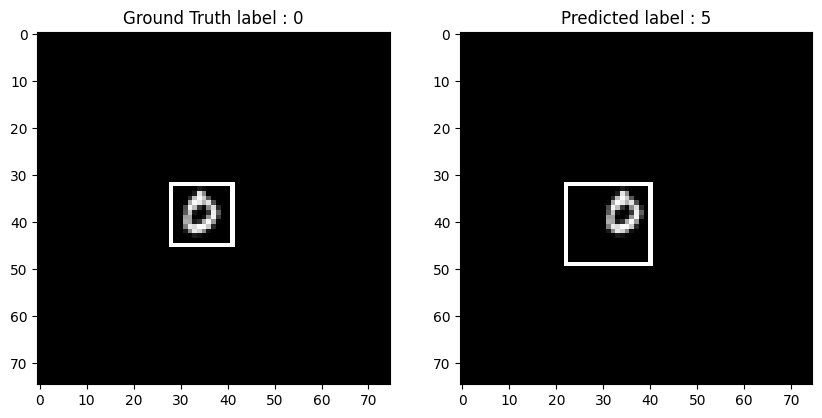

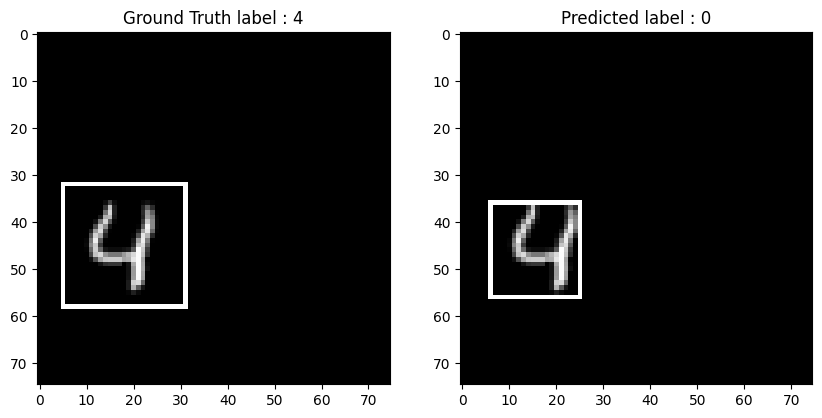

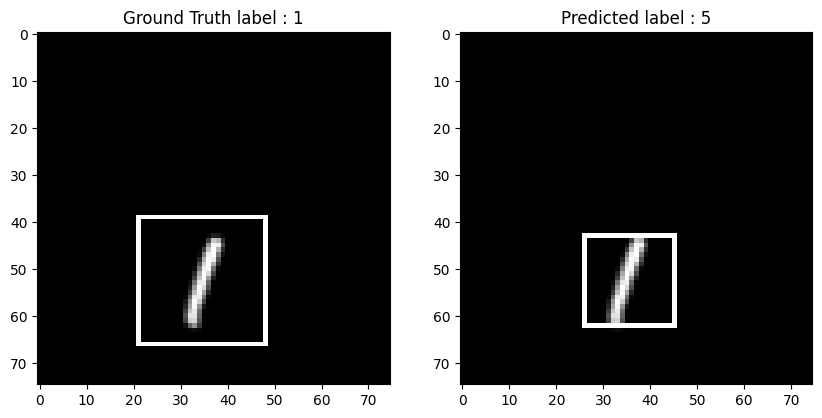

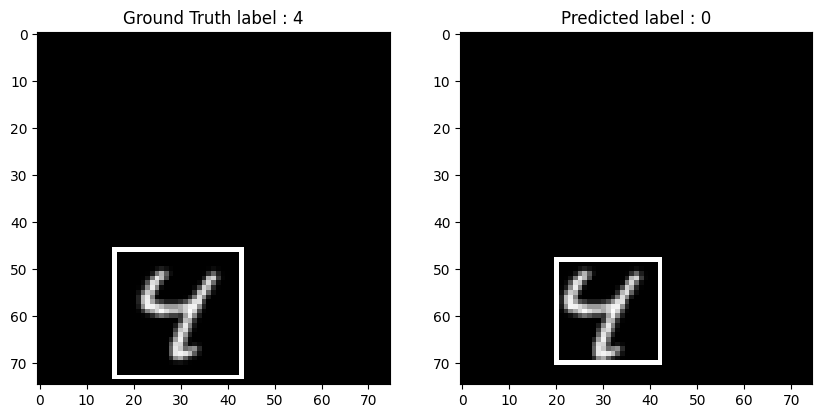

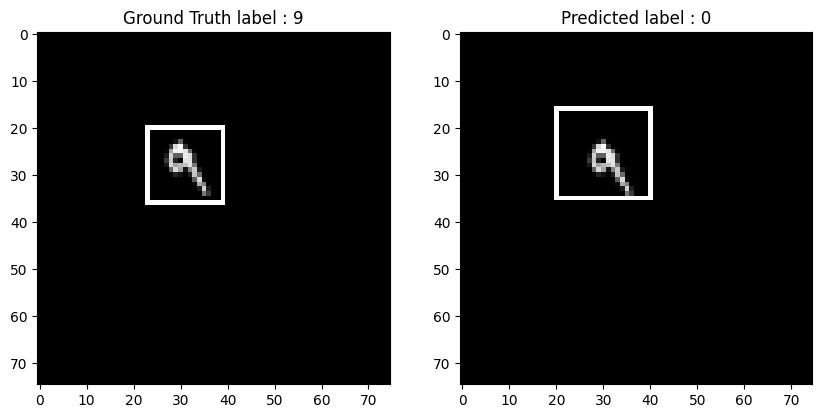

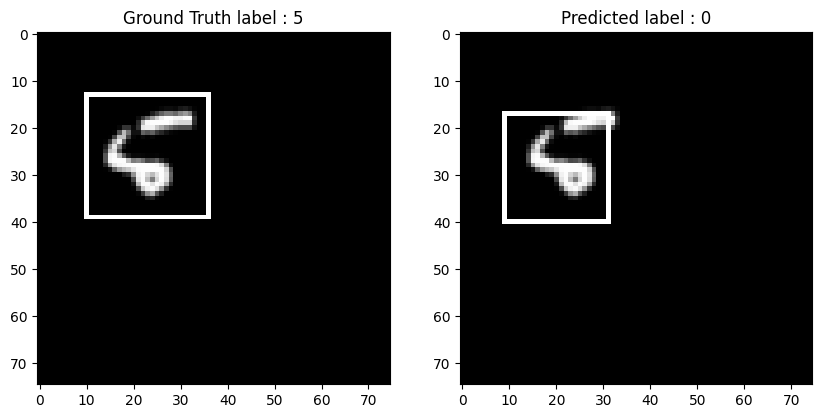

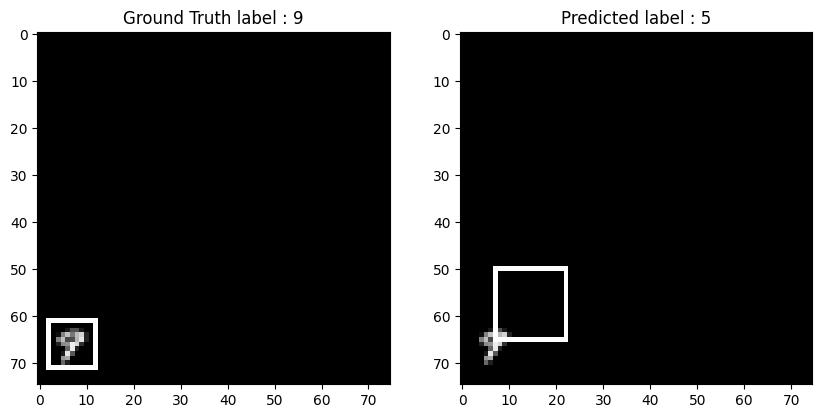

In [75]:
layers_dims = [w * h,80,40,20,10,14]         #  w * h is the dimension of input layer
activation_functions = ["", "relu","relu","relu","relu", "linear"]  # first column is blank because there is no activation from the input layer
learning_rate = 0.01
epochs = 50
mini_batch_size = 128

# Training our model using gradient descent
params, train_costs, test_costs , train_ious, test_ious = Gradient_Descent(train_x,train_y,learning_rate,epochs,mini_batch_size, layers_dims, activation_functions, test_x , test_y)

# plotting metrics of our model
plot_metrics(train_costs, test_costs, train_ious, test_ious, learning_rate)

# making prediction on our test set
for i in range(10):
    plot_bbox(i ,w,h,params,layers_dims,activation_functions)

100%|███████████████████████████████████████████| 60/60 [06:11<00:00,  6.20s/it]


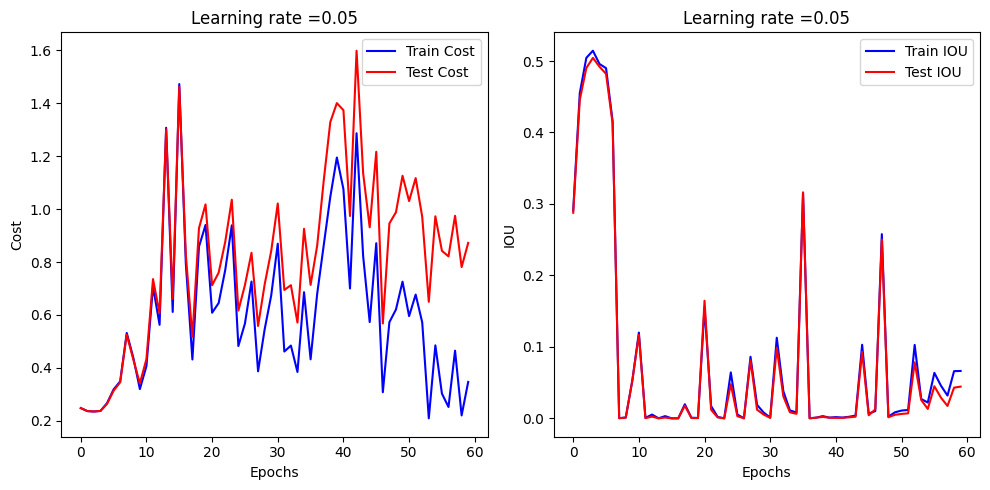

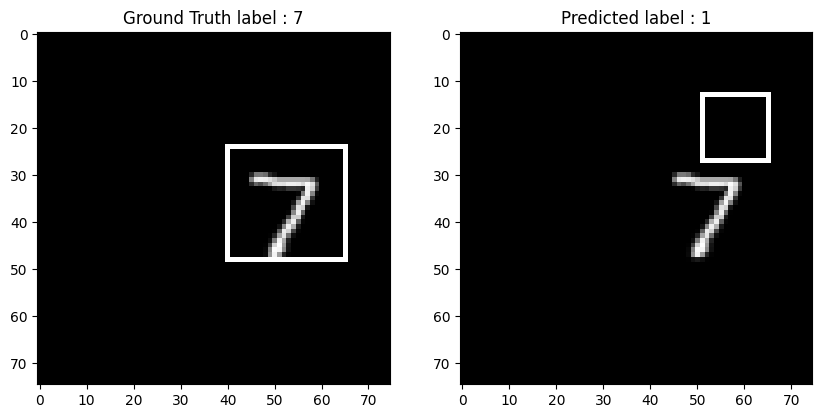

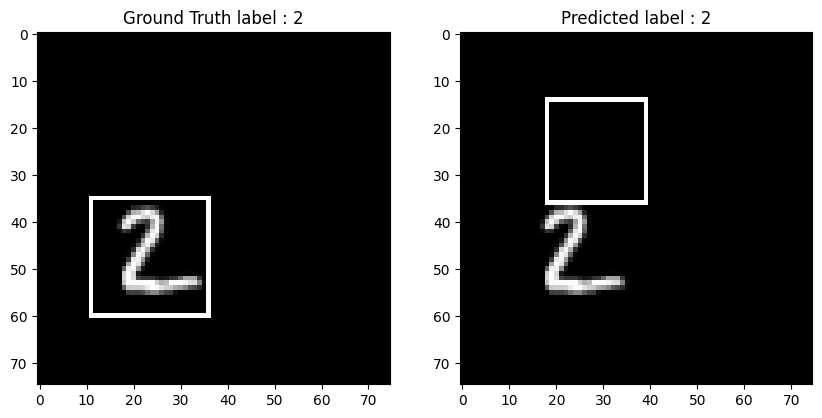

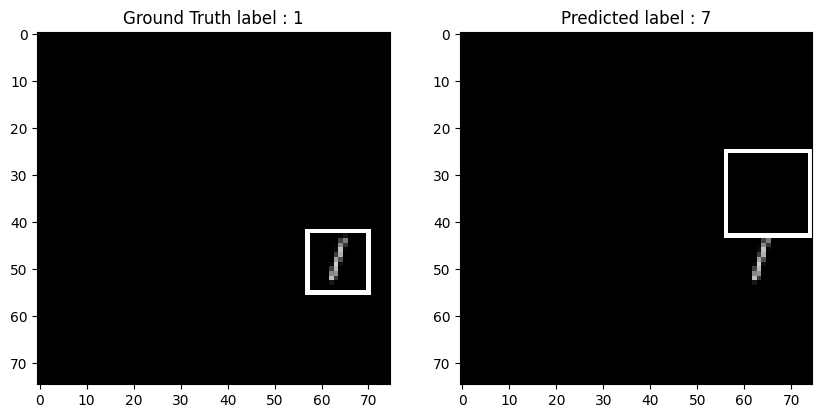

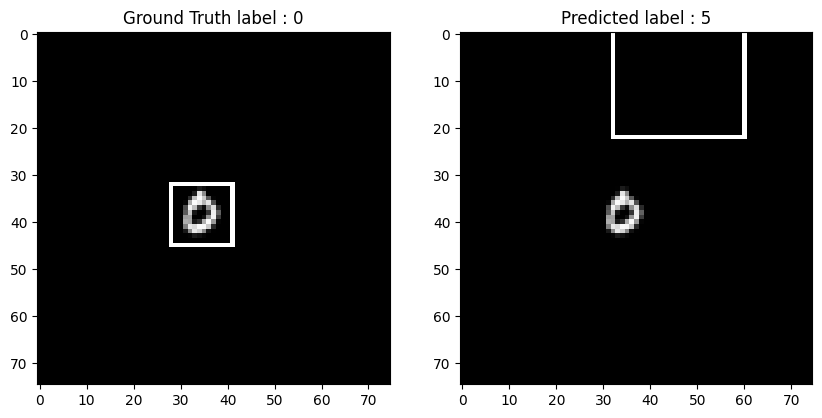

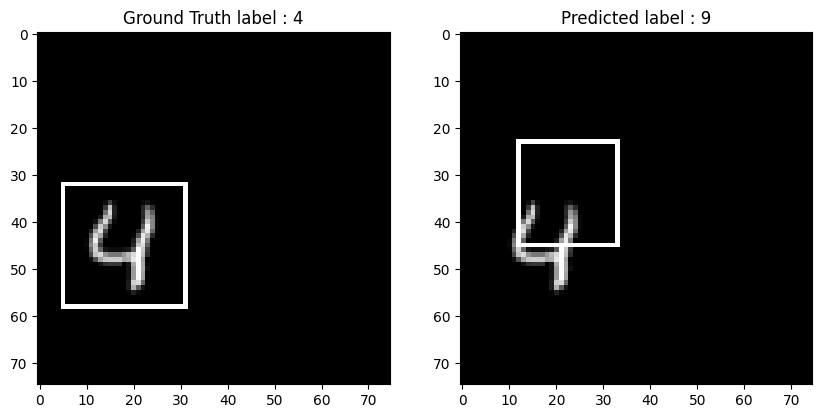

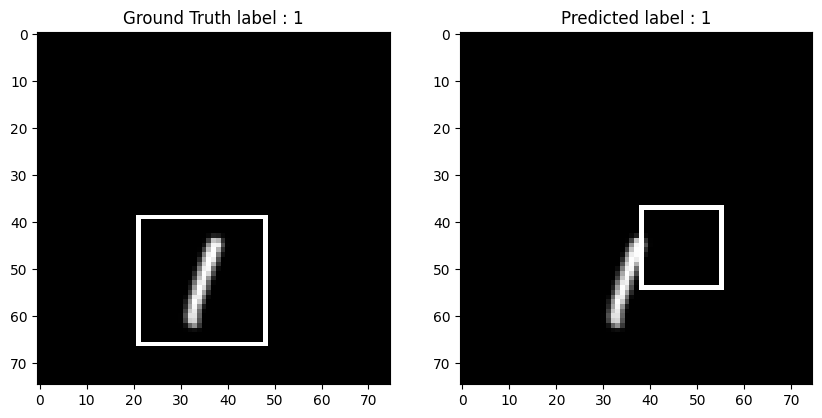

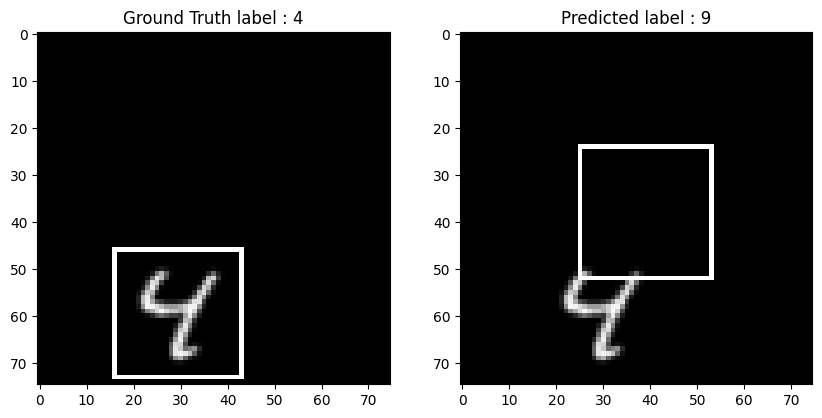

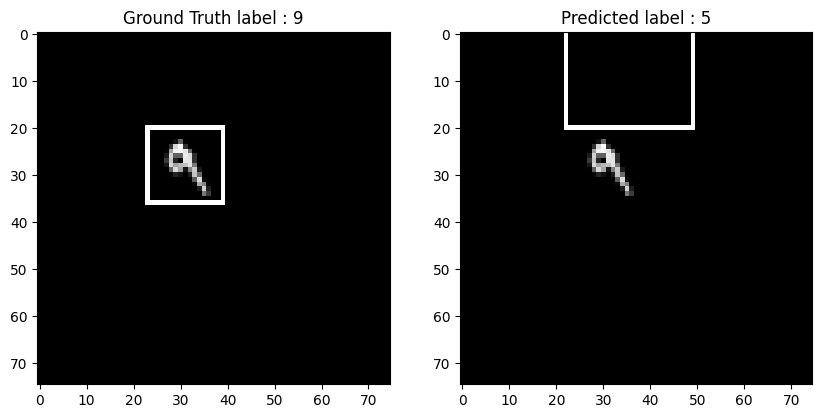

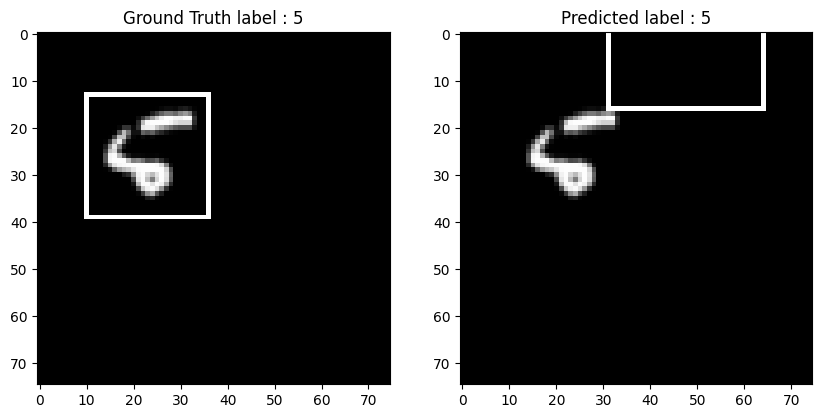

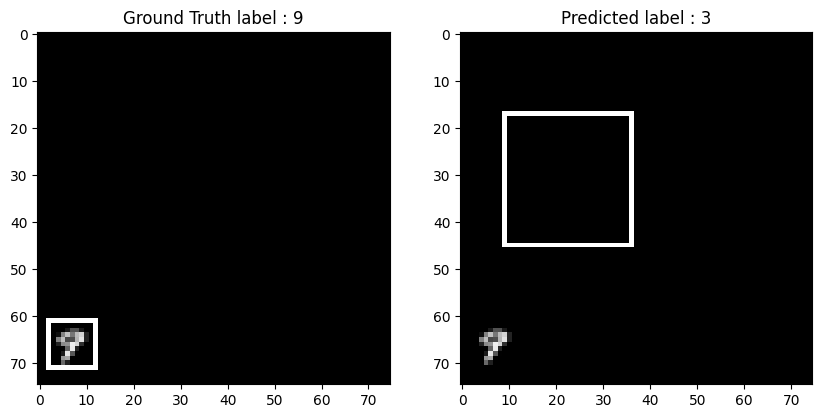

In [78]:
layers_dims = [w * h,160,80,40,20,10,14]         #  w * h is the dimension of input layer
activation_functions = ["", "relu","relu","relu","relu","relu", "linear"]  # first column is blank because there is no activation from the input layer
learning_rate = 0.05
epochs = 60
mini_batch_size = 64

# Training our model using gradient descent
params, train_costs, test_costs , train_ious, test_ious = Gradient_Descent(train_x,train_y,learning_rate,epochs,mini_batch_size, layers_dims, activation_functions, test_x , test_y)

# plotting metrics of our model
plot_metrics(train_costs, test_costs, train_ious, test_ious, learning_rate)

# making prediction on our test set
for i in range(10):
    plot_bbox(i ,w,h,params,layers_dims,activation_functions)

100%|███████████████████████████████████████████| 80/80 [07:38<00:00,  5.73s/it]


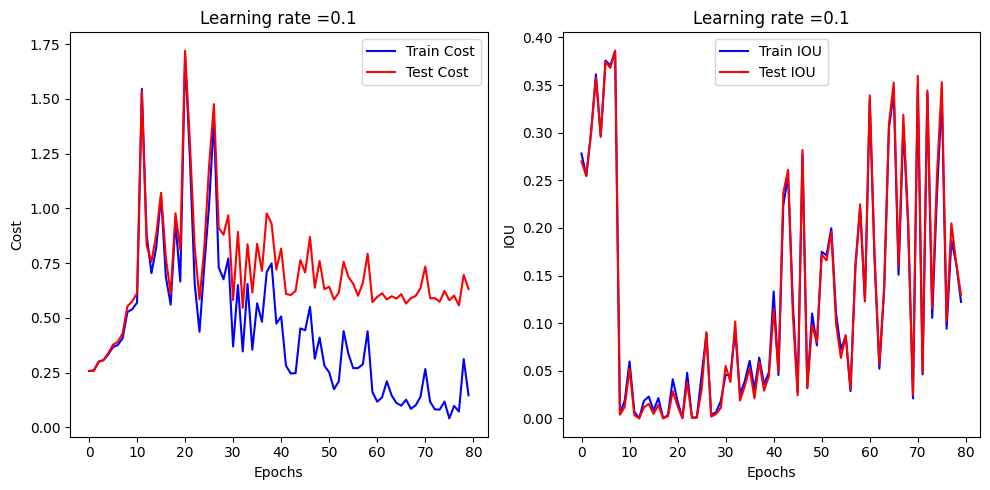

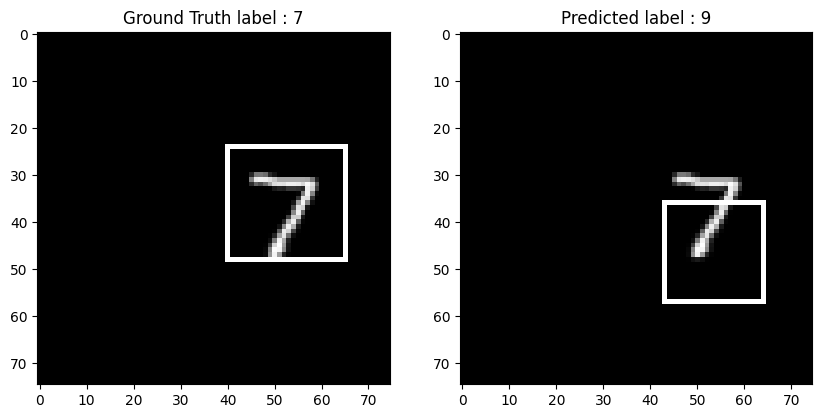

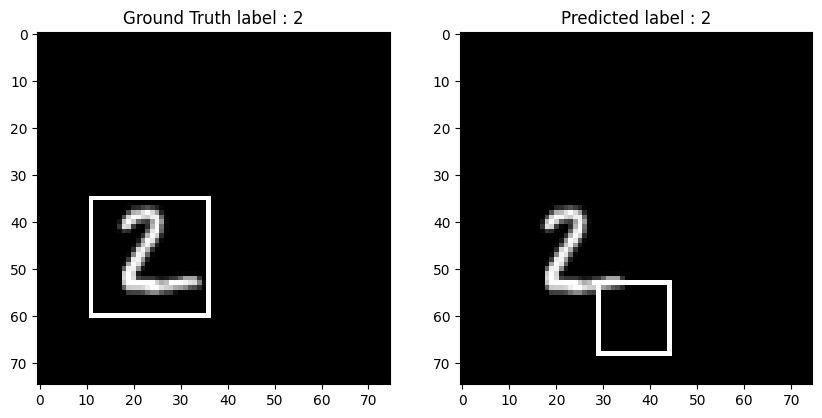

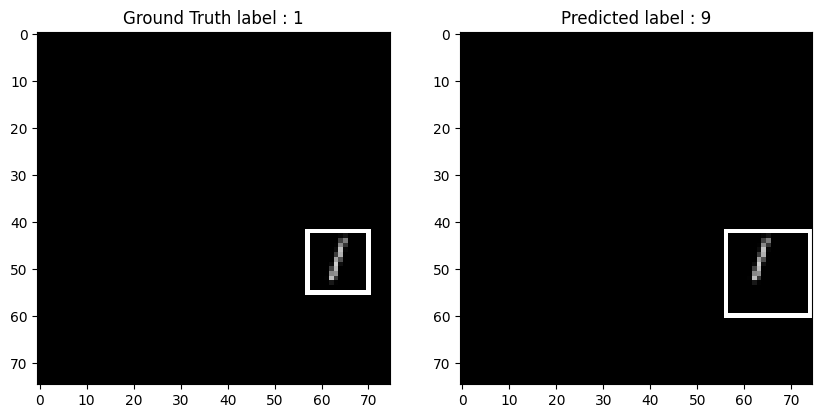

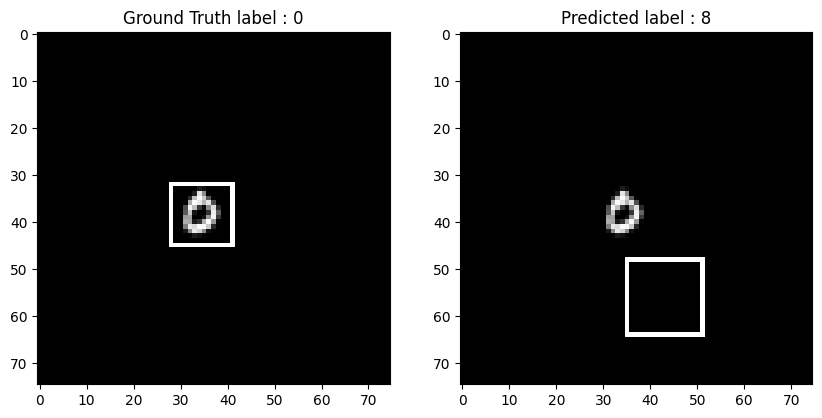

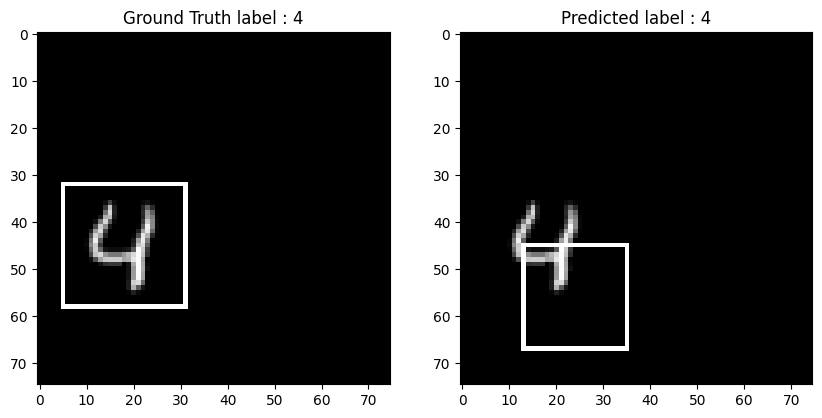

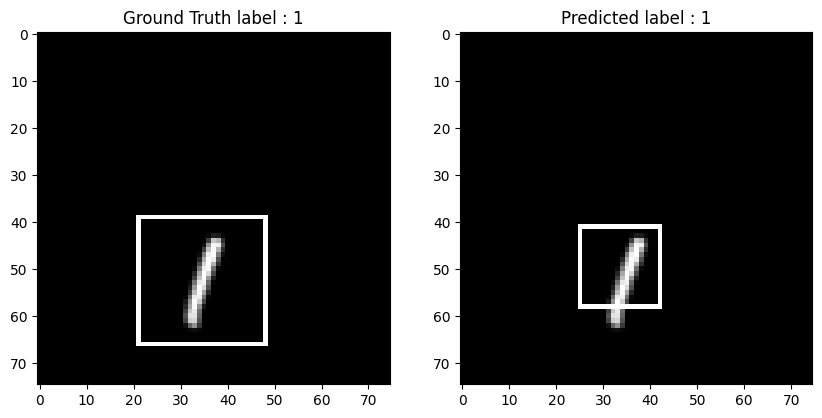

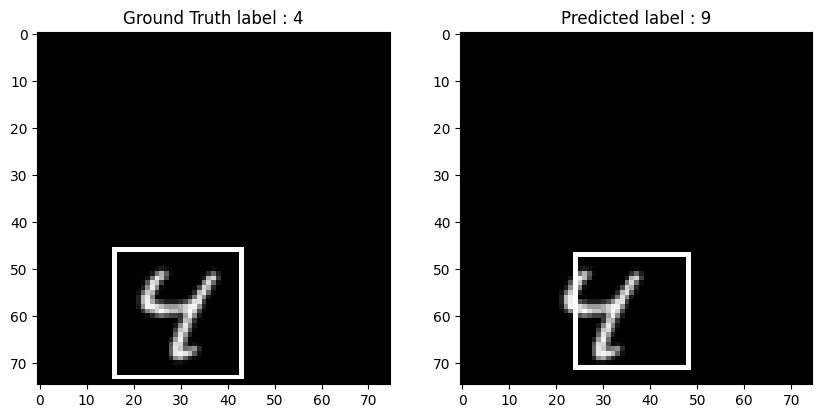

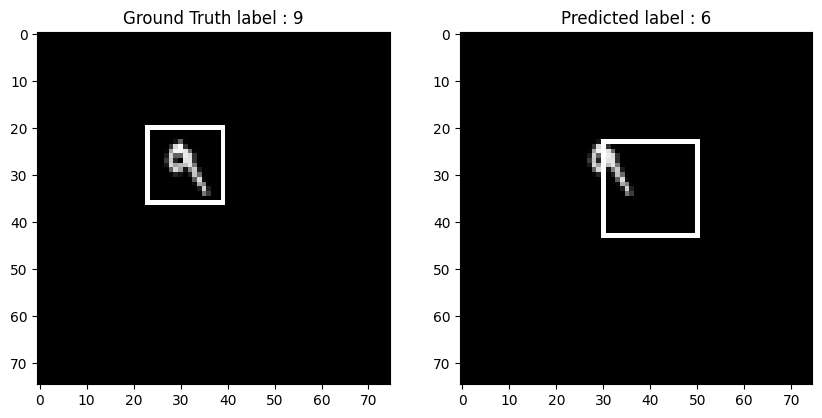

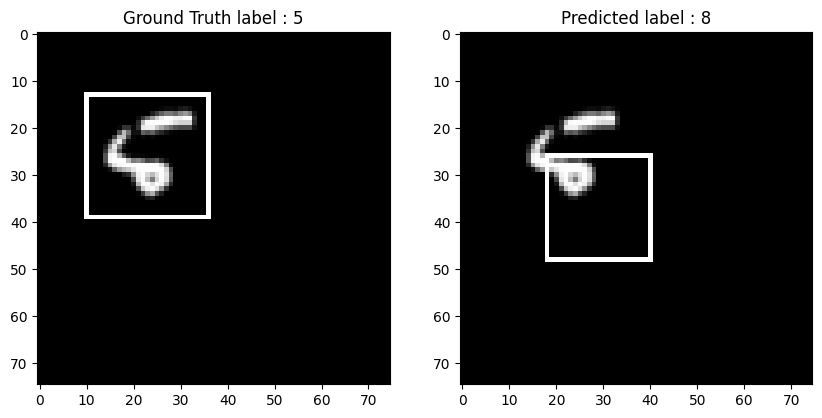

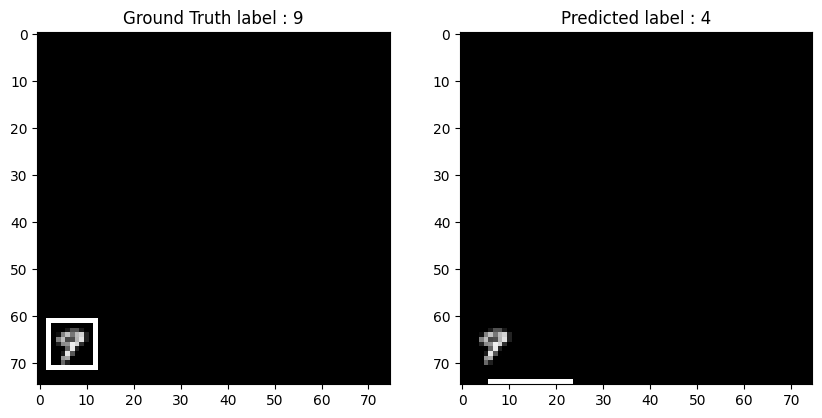

In [79]:
layers_dims = [w * h,160,80,40,20,10,14]         #  w * h is the dimension of input layer
activation_functions = ["", "relu","relu","relu","relu","relu", "linear"]  # first column is blank because there is no activation from the input layer
learning_rate = 0.1
epochs = 80
mini_batch_size = 64

# Training our model using gradient descent
params, train_costs, test_costs , train_ious, test_ious = Gradient_Descent(train_x,train_y,learning_rate,epochs,mini_batch_size, layers_dims, activation_functions, test_x , test_y)

# plotting metrics of our model
plot_metrics(train_costs, test_costs, train_ious, test_ious, learning_rate)

# making prediction on our test set
for i in range(10):
    plot_bbox(i ,w,h,params,layers_dims,activation_functions)

100%|███████████████████████████████████████████| 80/80 [09:45<00:00,  7.32s/it]


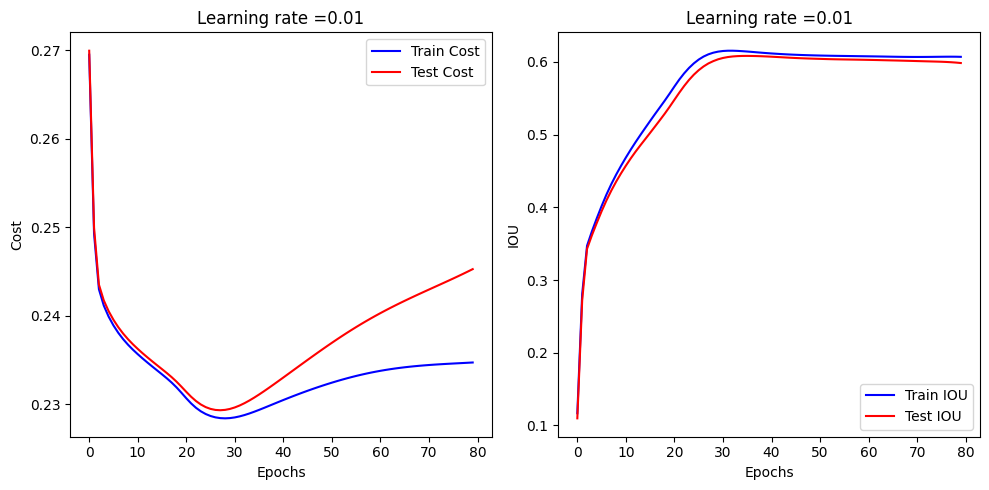

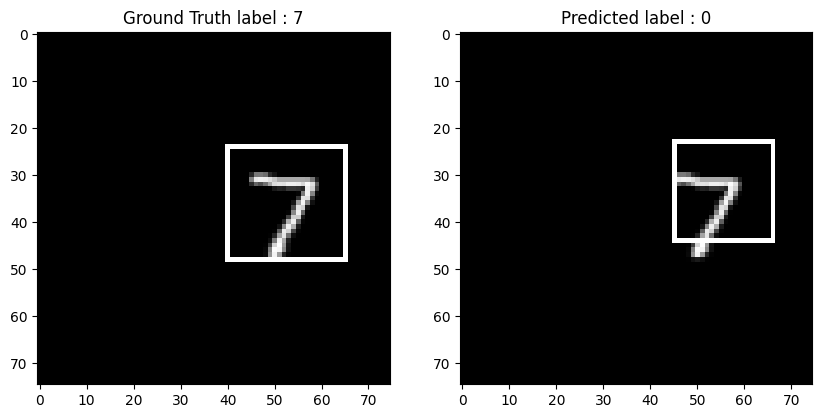

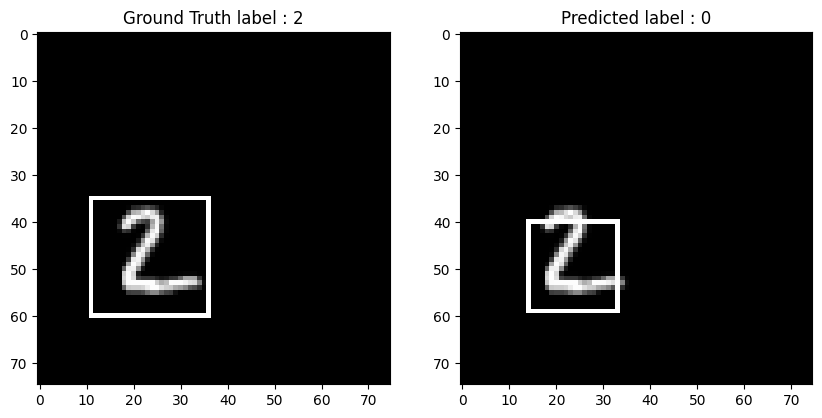

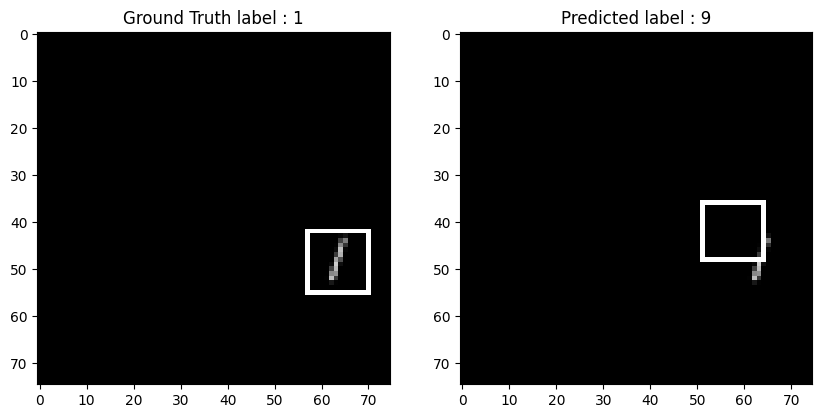

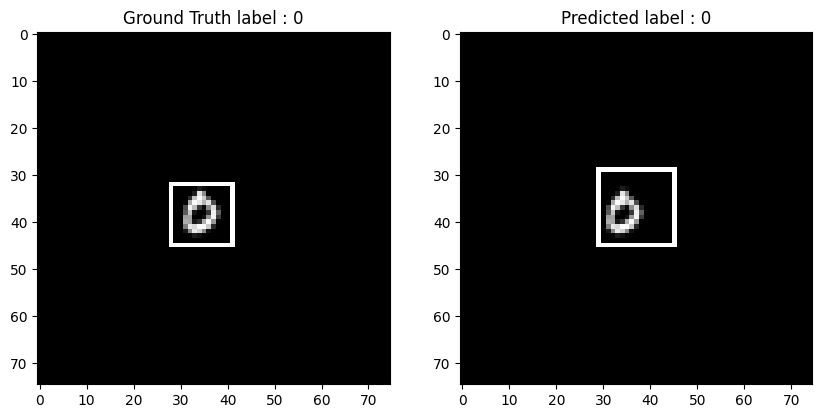

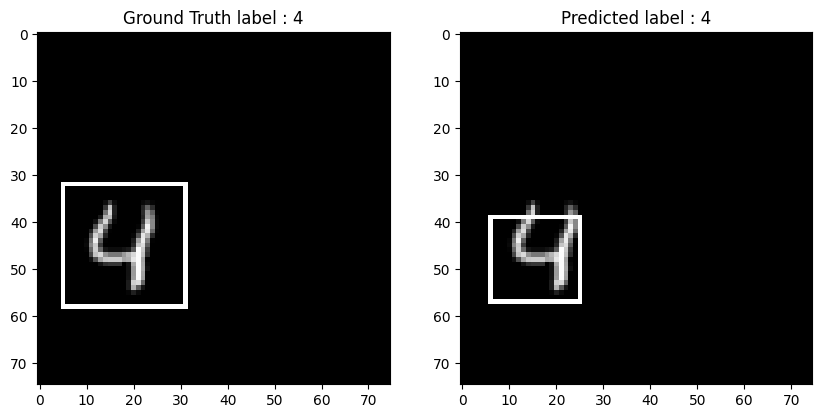

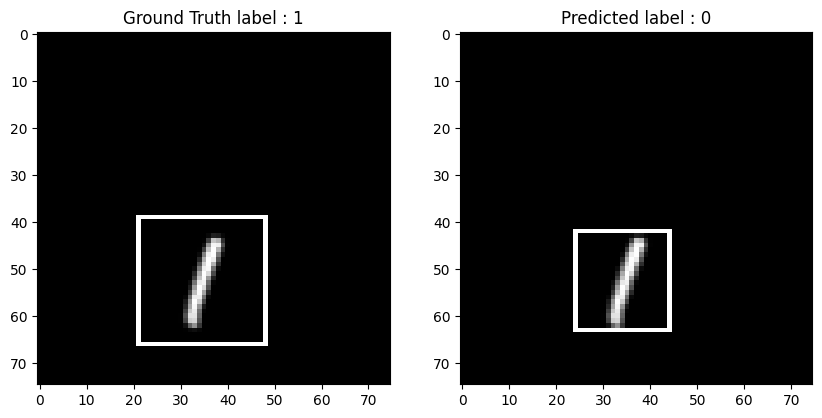

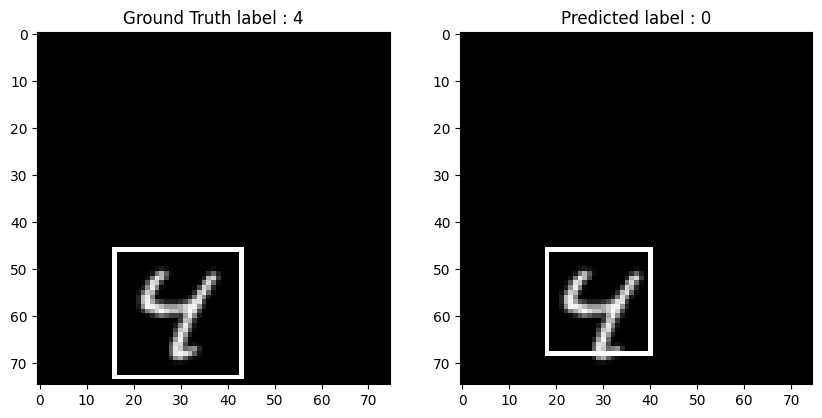

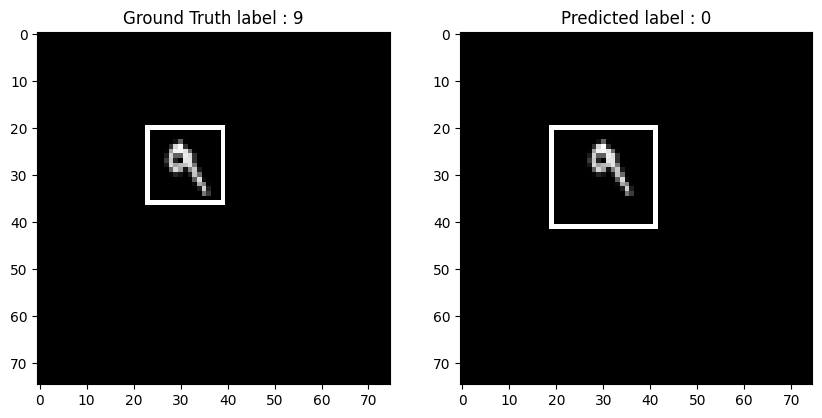

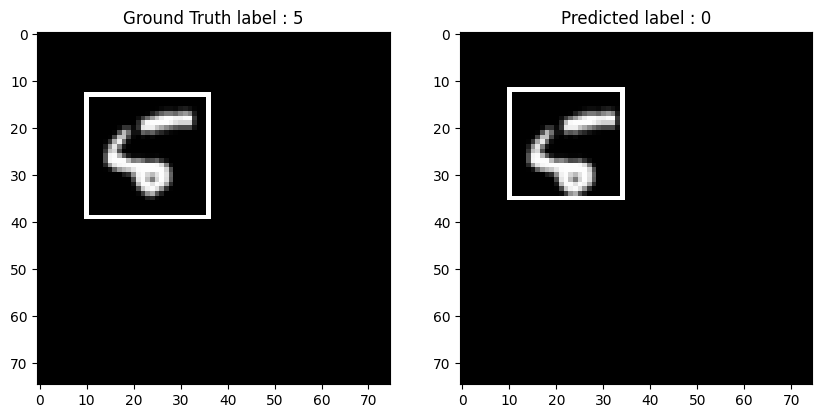

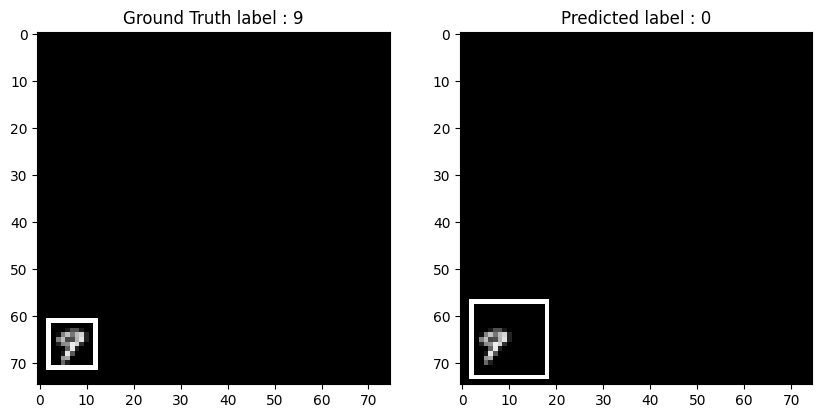

In [82]:
layers_dims = [w * h,160,80,40,20,10,14]         #  w * h is the dimension of input layer
activation_functions = ["", "tanh","tanh","tanh","tanh","tanh", "linear"]  # first column is blank because there is no activation from the input layer
learning_rate = 0.01
epochs = 80
mini_batch_size = 64

# Training our model using gradient descent
params, train_costs, test_costs , train_ious, test_ious = Gradient_Descent(train_x,train_y,learning_rate,epochs,mini_batch_size, layers_dims, activation_functions, test_x , test_y)

# plotting metrics of our model
plot_metrics(train_costs, test_costs, train_ious, test_ious, learning_rate)

# making prediction on our test set
for i in range(10):
    plot_bbox(i ,w,h,params,layers_dims,activation_functions)